In [1]:
# Necessary libraries

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

from src.swbm import *
from src.plots import *
from src.utils import *

In [2]:
# Load data

input_swbm_raw = pd.read_csv('data/Data_swbm_Germany.csv')
input_swbm = prepro(input_swbm_raw)

In [3]:
# Single paramter optimization

const_swbm_params = {'c_s': 420, 'b0': 0.8, 'g': .5, 'a': 4}

# Run SWBM without seasonal variation
moists, runoffs, ets = predict_ts(input_swbm, const_swbm_params)
eval_df = eval_swbm(input_swbm,
                    {'sm': moists, 'ro': runoffs, 'le': ets},
                    'None\nSeasonal')

# ---- Seasonal Variation for single parameter
param_opt_sin_init = {'b0': [0.5, 2, 5, 0.8],
                      'g': [0.1, 2, 5, 0.5],
                      'a': [1, 2, 5, 4]}

for swbm_param, init_values in param_opt_sin_init.items():
    np.random.seed(42)
    const_swbm_params = {'c_s': 420, 'b0': 0.8, 'g': .5, 'a': 4}
    res = minimize(opt_swbm_corr,
                   np.asarray(init_values).flatten(),  # has to be 1D
                   args=(input_swbm, const_swbm_params, swbm_param),
                   options={"maxiter": 500, "disp": True})
    opt_params_df = minimize_res2df(res, [swbm_param])

    # Set swbm const_swbm_params
    params_seasonal = {'c_s': 420, 'b0': 0.8, 'g': .5, 'a': 4}
    # Get sinus curve for current single parameter
    params_seasonal[swbm_param] = seasonal_sinus(
        len(input_swbm),
        amplitude=opt_params_df.loc['amplitude', swbm_param],
        freq=opt_params_df.loc['freq', swbm_param],
        phase=opt_params_df.loc['phase', swbm_param],
        center=opt_params_df.loc['center', swbm_param],
        which=swbm_param
    )

    # Run SWBM
    preds_seasonal = predict_ts(input_swbm, params_seasonal)
    moists_seasonal, runoffs_seasonal, ets_seasonal = preds_seasonal
    # Test correlation
    eval_df = pd.concat((eval_df, eval_swbm(input_swbm,
                                            {'sm': moists_seasonal,
                                             'ro': runoffs_seasonal,
                                             'le': ets_seasonal},
                                            swbm_param)))

Optimization terminated successfully.
         Current function value: -0.893547
         Iterations: 12
         Function evaluations: 75
         Gradient evaluations: 15
Optimization terminated successfully.
         Current function value: -0.892720
         Iterations: 39
         Function evaluations: 225
         Gradient evaluations: 45
Optimization terminated successfully.
         Current function value: -0.892587
         Iterations: 54
         Function evaluations: 310
         Gradient evaluations: 62


In [4]:
# ---- Optimize all

# initialize parameters and sinus const_swbm_params
init_sinus_params_all = [[0.5, 2, 5, 420],
                         # c_s (amplitude, freq, phase, center)
                         [0.5, 2, 5, 0.8],  # b0 -> max. ET
                         [0.1, 2, 5, 0.5],  # g -> ET function shape
                         [1, 2, 5, 4]]  # a -> runoff function shape
make_seasonal_all = ['c_s', 'b0', 'g', 'a']

# optimize sinus parameters
np.random.seed(42)
res_all = minimize(opt_swbm_corr,
                   np.asarray(init_sinus_params_all).flatten(),  # has to be 1D
                   args=(input_swbm, {}, make_seasonal_all),
                   options={"maxiter": 500, "disp": True})
# extract optimized sinus parameters
opt_params_all_df = minimize_res2df(res_all, make_seasonal_all)

# get optimized seasonal parameters
opt_sinus_all = {}
for swbm_param in opt_params_all_df:
    opt_sinus_all[swbm_param] = seasonal_sinus(
        len(input_swbm),
        amplitude=opt_params_all_df.loc['amplitude', swbm_param],
        freq=opt_params_all_df.loc['freq', swbm_param],
        phase=opt_params_all_df.loc['phase', swbm_param],
        center=opt_params_all_df.loc['center', swbm_param],
        which=swbm_param
    )

# Run SWBM
preds_all = predict_ts(input_swbm, opt_sinus_all)
preds_seasonal_all = {'sm': preds_all[0],
                      'ro': preds_all[1],  # messed up sinus phase here
                      'le': preds_all[2]}
# get correlations
eval_df = pd.concat((eval_df, eval_swbm(input_swbm, preds_seasonal_all, 'all')))

Optimization terminated successfully.
         Current function value: -0.936783
         Iterations: 167
         Function evaluations: 3026
         Gradient evaluations: 178


In [5]:
# ---- Optimize all except for one parameter

init_sinus_params_all = np.asarray(init_sinus_params_all)
for i, swbm_param in enumerate(make_seasonal_all):
    const_swbm_params = {'c_s': 420, 'b0': 0.8, 'g': .5, 'a': 4}
    # optimize sinus parameters
    np.random.seed(42)
    # exclude current param. from init values and list of params
    make_seasonal_tmp = [p for p in make_seasonal_all if p != swbm_param]
    init_sinus_params_tmp = np.delete(init_sinus_params_all, i, axis=0)
    res_tmp = minimize(opt_swbm_corr,
                       init_sinus_params_tmp.flatten(),
                       # has to be 1D
                       args=(input_swbm, const_swbm_params, make_seasonal_tmp),
                       options={"maxiter": 500, "disp": True})
    # extract optimized sinus parameters
    opt_params_df = minimize_res2df(res_tmp, make_seasonal_tmp)

    # get optimized seasonal parameters
    opt_sinus = {'c_s': 420, 'b0': 0.8, 'g': .5, 'a': 4}
    for p in opt_params_df:
        opt_sinus[p] = seasonal_sinus(
            len(input_swbm),
            amplitude=opt_params_df.loc['amplitude', p],
            freq=opt_params_df.loc['freq', p],
            phase=opt_params_df.loc['phase', p],
            center=opt_params_df.loc['center', p],
            which=p
        )

    # Run SWBM
    model_sm, model_ro, model_le = predict_ts(input_swbm, opt_sinus)
    preds_seasonal = {'sm': model_sm, 'ro': model_ro, 'le': model_le}
    # get correlations
    eval_df = pd.concat(
        (eval_df, eval_swbm(input_swbm, preds_seasonal, f'not {swbm_param}')))

# get parameter importance
reference_corr = (eval_df[(eval_df['parameter'] == 'all')
                          & (eval_df['kind'] == 'sm')]['corr'].values[0])
is_excluded = eval_df['parameter'].isin(['not b0', 'not g', 'not a', 'not c_s'])
excl_corr = eval_df[(eval_df['kind'] == 'sm') & is_excluded]
# Extract feature importances
feature_importances = (
    excl_corr.assign(parameter=lambda x: x['parameter'].str.replace('not ', ''),
                     # Remove "not " from parameter names
                     feature_importance=lambda x: reference_corr - x['corr'])
    [['parameter', 'feature_importance']]
)
# plot parameter importance
plot_param_importance(feature_importances,
                      save='figs/model_selection/importance.pdf')

# average across sm, ro and et correlation and plot scores
plot_avg_scores(eval_df, save='figs/model_selection/compare_models_scores.pdf')

c:\Users\motze\programs\Miniconda3\envs\esm\Lib\site-packages\scipy\optimize\_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: -0.930619
         Iterations: 80
         Function evaluations: 2176
         Gradient evaluations: 167
Optimization terminated successfully.
         Current function value: -0.912412
         Iterations: 105
         Function evaluations: 1469
         Gradient evaluations: 113


c:\Users\motze\OneDrive\Master\ESM\VegSWBM\src\swbm.py:5: RuntimeWarning: invalid value encountered in scalar power
  return b0 * (w_i / c_s) ** g
c:\Users\motze\OneDrive\Master\ESM\VegSWBM\src\swbm.py:9: RuntimeWarning: invalid value encountered in scalar power
  return (w_i / c_s) ** a


ValueError: array must not contain infs or NaNs

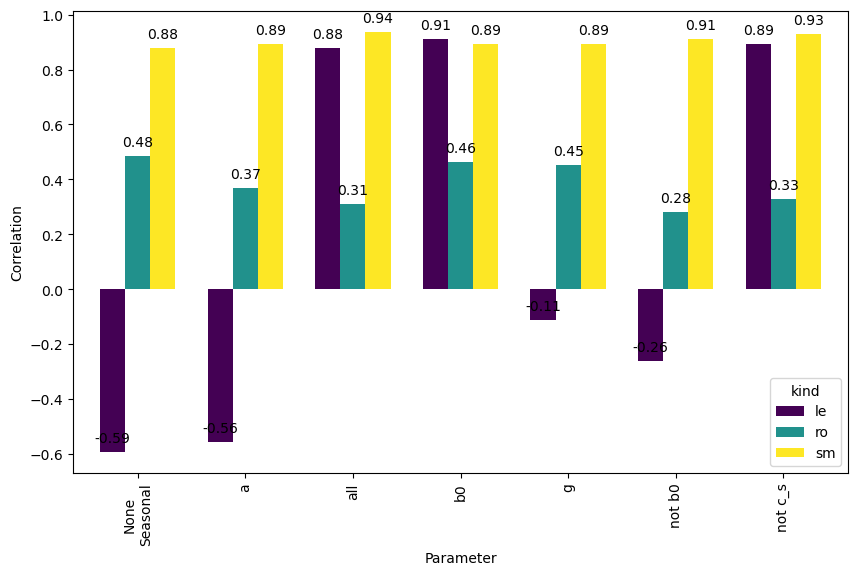

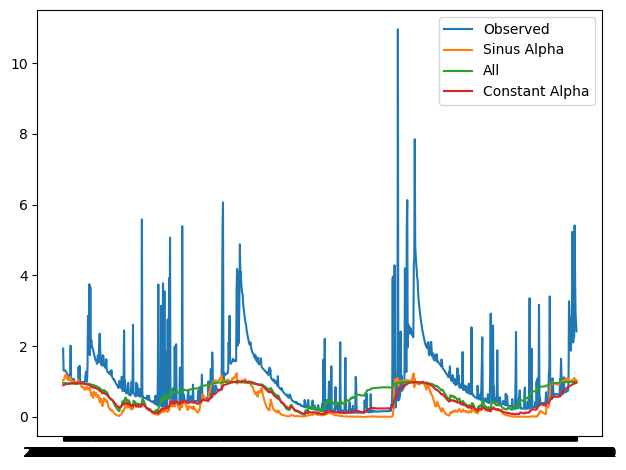

In [6]:
# Plot single opt results
pivot_df = eval_df.pivot(index='parameter', columns='kind',
                         values='corr')

ax = pivot_df.plot(kind='bar', width=0.7, figsize=(10, 6), colormap='viridis')
for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points')
# Adding labels and title
ax.set_xlabel('Parameter')
ax.set_ylabel('Correlation')

# Show the plot
plt.show()
plt.savefig('figs/model_selection/all_corr.pdf')
plt.close('all')

# whats wrong with runoff
input_swbm_time = input_swbm.copy()
input_swbm_time['time'] = [date.format('YYYY-MM-DD')
                            for date in input_swbm['time']]
year_mask = [arrow.get(date).year == 2010 or arrow.get(date).year == 2011 or
             arrow.get(date).year == 2012 for date in input_swbm['time']]
plt.plot(input_swbm_time['time'][year_mask], input_swbm_time['ro'][year_mask],
         label='Observed')
plt.plot(input_swbm_time['time'][year_mask], runoffs_seasonal[year_mask],
         label='Sinus Alpha')
plt.plot(input_swbm_time['time'][year_mask], preds_all[1][year_mask],
         label='All')
plt.plot(input_swbm_time['time'][year_mask], runoffs[year_mask],
         label='Constant Alpha')
plt.legend()
plt.tight_layout()
plt.show()
#plt.savefig('figs/model_selection/compare_runoffs.pdf')